In [90]:
import cv2
import numpy as np
import scipy.ndimage as sn
import copy
import imutils
from matplotlib import pyplot as plt
from PIL import ImageEnhance, Image
from skimage.feature import peak_local_max
from skimage import color
from numpy.random import default_rng
from queue import Queue

In [4]:
# Importing Data

In [86]:
image_1 = cv2.imread('data\im1.jpg')
gold_mask_1 = np.loadtxt("data\im1_gold_mask.txt")
gold_cells_1 = np.loadtxt("data\im1_gold_cells.txt",'uint16')


image_2 = cv2.imread('data\im2.jpg')
gold_mask_2 = np.loadtxt("data\im2_gold_mask.txt")
gold_cells_2 = np.loadtxt("data\im2_gold_cells.txt",'uint16')


image_3 = cv2.imread('data\im3.jpg')
gold_mask_3 = np.loadtxt("data\im3_gold_mask.txt")
gold_cells_3 = np.loadtxt("data\im3_gold_cells.txt",'uint16')

#Check
#print(image_1)
#print(gold_mask_1)

In [136]:
def Increase_Contrast(image):
    to_increase_contrast = cv2.fastNlMeansDenoising(image,None,3,7,21)
    to_increase_contrast = Image.fromarray(to_increase_contrast)
    getting_contrast = ImageEnhance.Contrast(to_increase_contrast)
    increased_contrast = getting_contrast.enhance(1.5)
    increased_contrast = np.asarray(increased_contrast)
    return increased_contrast

def reset_queu(image, mask, cell, index, arr, mark):
    mark[cell] = 1
    dirs = [[-1,0],[0,-1],[0,1],[1,0]]
    q = Queue()
    q.put((cell, 0))
    arr[cell] = index

    while not q.empty():
        first, depth = q.get()
        if depth == 41:
            continue
    for dir in dirs:
        next = (dir[0] + first[0], dir[1] + first[1])
        if(region_cehck(next, mask, image, mark)):
            mark[next] = 1
            q.put((next, depth+1))
            arr[next] = index


In [7]:
increased_contrast_1=Increase_Contrast(image_1)
increased_contrast_2=Increase_Contrast(image_2)
increased_contrast_3=Increase_Contrast(image_3)

In [8]:
#increased_contrast_1

In [27]:
def Gray_image(increased_contrast):
    blur = cv2.GaussianBlur(increased_contrast, (3,3), 0)
    gray_image = blur[:,:,0]
    limit=np.mean(gray_image)
    return gray_image,limit
def Gray_image_cell(image,mask):
    mask[mask == [1]] = 255
    image = cv2.GaussianBlur(image, (5,5), 0)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    r_image = masked_image[:,:,0]
    return r_image
gray_image_1, limit_1 = Gray_image(increased_contrast_1)
gray_image_2, limit_2 = Gray_image(increased_contrast_2)
gray_image_3, limit_3 = Gray_image(increased_contrast_3)

In [28]:
 def Sharpened(gray_image):
    kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)
    log_image = cv2.filter2D(gray_image, cv2.CV_32F, kernel)
    log_image = np.absolute(log_image)
    sharp = np.float32(gray_image)
    res_image = sharp + 2 * log_image
    res_image = np.clip(res_image, 0, 255)
    res_image = res_image.astype('uint8')
    log_image = np.clip(log_image, 0, 255)
    log_image = log_image.astype('uint8')
    return res_image
 def Sharpened_cell(gray_image):
    kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)
    log_image = cv2.filter2D(gray_image, cv2.CV_32F, kernel)
    log_image = np.absolute(log_image)
    sharp = np.float32(gray_image)
    res_image = sharp - log_image
    res_image = np.clip(res_image, 0, 255)
    res_image = res_image.astype('uint8')
    log_image = np.clip(log_image, 0, 255)
    log_image = log_image.astype('uint8')
    return res_image

res_image_1 = Sharpened(gray_image_1)
res_image_2 = Sharpened(gray_image_2)
res_image_3 = Sharpened(gray_image_3)

In [29]:
def Get_foregound_mask(res_image,limit):
    a, foreground_mask = cv2.threshold(res_image, limit, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    foreground_mask = cv2.morphologyEx(foreground_mask, cv2.MORPH_OPEN, kernel, iterations = 4)
    foreground_mask = cv2.morphologyEx(foreground_mask, cv2.MORPH_CLOSE, kernel, iterations = 13)
    foreground_mask[foreground_mask==255] = 1
    return foreground_mask
foreground_mask_1 = Get_foregound_mask(res_image_1,limit_1)
foreground_mask_2 = Get_foregound_mask(res_image_2,limit_2)
foreground_mask_3 = Get_foregound_mask(res_image_3,limit_3)

In [30]:
def Plots(image,foreground_mask,gold_mask,file):
    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
   

    fig.add_subplot(131)
    plt.title('Orignal')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    fig.add_subplot(132)
    plt.title('Found')
    plt.set_cmap('gray')
    plt.imshow(foreground_mask)

    fig.add_subplot(133)
    plt.title('Given')
    plt.set_cmap('gray')
    plt.imshow(gold_mask)
    
    save_file=file+'.png'
    plt.savefig(save_file)
    
   

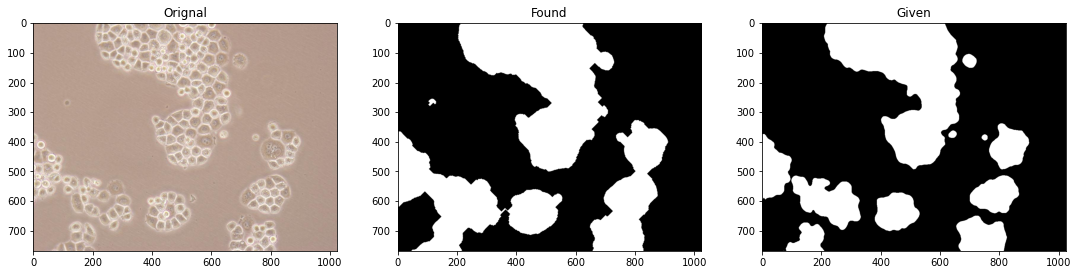

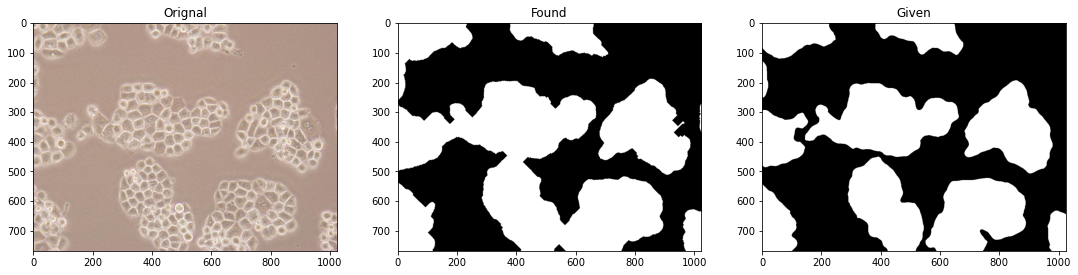

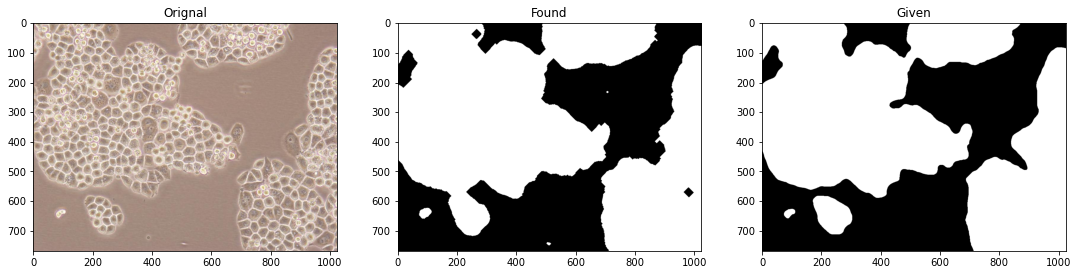

In [31]:
Plots(image_1,foreground_mask_1,gold_mask_1,"1")
Plots(image_2,foreground_mask_2,gold_mask_2,"2")
Plots(image_3,foreground_mask_3,gold_mask_3,"3")

In [67]:


def Calculated_Metrics(foreground_mask,gold_mask,image_number):
    tp = 0.0
    fp = 0.0
    fn_number = 0.0
    rows, cols = np.shape(foreground_mask_1)
    for row in range(rows):
        for index in range(cols):
            if foreground_mask[row][index] == 1 and gold_mask[row][index] == 1:
                tp = tp+ 1
            if foreground_mask[row][index] == 1 and gold_mask[row][index] == 0:
                fp = fp+ 1
            if foreground_mask[row][index] == 0 and gold_mask[row][index] == 1:
                fn_number = fn_number+ 1

    precision = tp/(tp + fp)
    recall =  tp/(tp + fn_number)
    F_score = tp/(tp+(1/2*(fp+fn_number)))
    print(" Image %s \n Pixel-level precision: %f \n Recall: %f \n F-score: %f"% (image_number,precision,recall,F_score))

def find_center(c):
    M = cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return (cY, cX)

In [68]:
tp = 0.0
fp = 0.0
fn_number = 0.0
Calculated_Metrics(foreground_mask_1,gold_mask_1,"1")
tp = 0.0
fp = 0.0
fn_number = 0.0
Calculated_Metrics(foreground_mask_2,gold_mask_2,"2")
tp = 0.0
fp = 0.0
fn_number = 0.0
Calculated_Metrics(foreground_mask_3,gold_mask_3,"3")

ZeroDivisionError: float division by zero

In [70]:

def Get_Cells(image,limit,mask):
    r_image = Gray_image_cell(image,mask)
    g_image = r_image
    
    kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)
    log_image = cv2.filter2D(g_image, cv2.CV_32F, kernel)



    log_image = np.absolute(log_image)
    sharp = np.float32(g_image)
    res_image = sharp - log_image

    res_image = np.clip(res_image, 0, 255)
    res_image = res_image.astype('uint8')
    log_image = np.clip(log_image, 0, 255)
    log_image = log_image.astype('uint8')

    a, foreground_mask = cv2.threshold(res_image, limit, 255, cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    foreground_mask = cv2.morphologyEx(foreground_mask, cv2.MORPH_OPEN, kernel, iterations = 5)


    cells = cv2.bitwise_not(foreground_mask, mask = mask)

    distance = cv2.distanceTransform(cells, cv2.DIST_L2, 3)
    cv2.normalize(distance, distance, 0, 255, cv2.NORM_MINMAX)

    distance = cv2.erode(distance, kernel, iterations = 3)
    distance = cv2.morphologyEx(distance, cv2.MORPH_OPEN, kernel, iterations = 5)


    a, foreground_mask = cv2.threshold(distance, 1, 255, cv2.THRESH_BINARY)

    foreground_mask = foreground_mask.astype('uint8')
    
    contours = cv2.findContours(foreground_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    center = [find_center(c) for c in contours]
    for c in (contours):
        M = cv2.moments(c)
        centerX = int(M["m10"] / M["m00"])
        centerY = int(M["m01"] / M["m00"])
        #center.append([centerX,centerY])
    
    return center, distance

(193, 2)
(768, 1024)


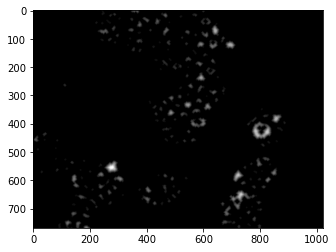

In [71]:

plt.imshow(distance)
print(np.shape(center_cordinate))
print(np.shape(distance))

In [76]:
def xy_image(xy, shape):
    image = np.zeros(shape, 'uint8')
    for center in xy:
        image[center] = 1
    return image
center_cordinate_1, distance_1 = Get_Cells(image_1,limit_1,foreground_mask_1)
center_cordinate_2, distance_2 = Get_Cells(image_2,limit_2,foreground_mask_2)
center_cordinate_3, distance_3 = Get_Cells(image_3,limit_3,foreground_mask_3)
xy_image_version1 = xy_image(center_cordinate_1, distance_1.shape)
xy_image_version2 = xy_image(center_cordinate_2, distance_2.shape)
xy_image_version3 = xy_image(center_cordinate_3, distance_3.shape)

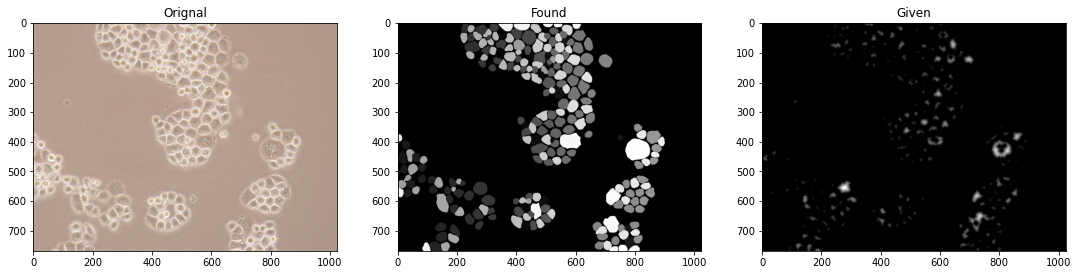

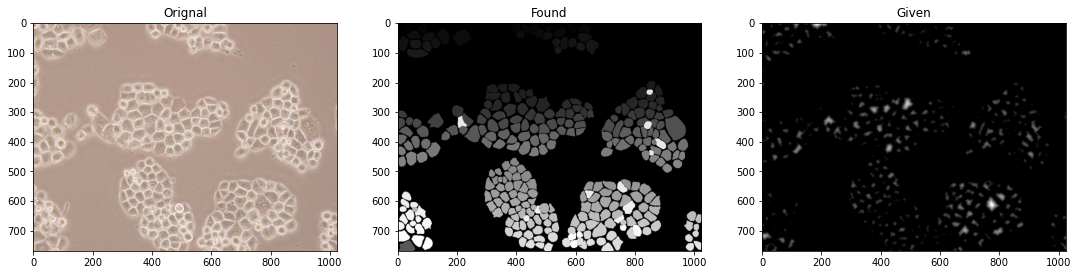

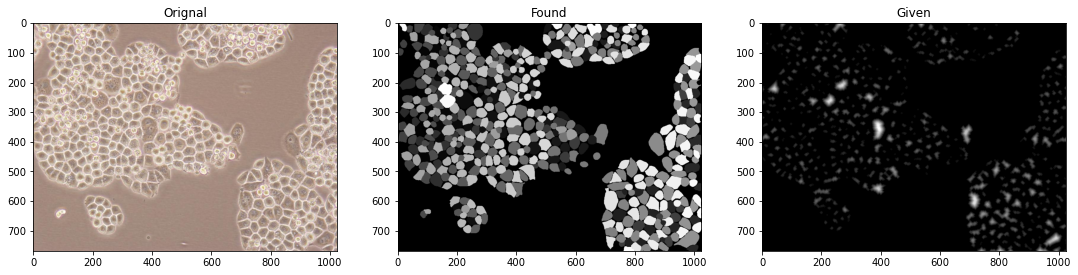

In [77]:
Plots(image_1,gold_cells_1,distance_1.copy(),"1")
Plots(image_2,gold_cells_2,distance_2.copy(),"2")
Plots(image_3,gold_cells_3,distance_3.copy(),"3")


In [84]:
def Calculated_Metrics_Cell(ground_truth,found,image_number):
    tp = 0.0
    nm = np.max(ground_truth)
    for i in range(1, nm + 1):
        one_count = np.sum(np.logical_and(ground_truth == i, found == 1))
        if one_count == 1:
            tp += 1
    fp = np.sum(np.logical_and(ground_truth == 0, found == 1))
    fn_number = np.max(ground_truth) - calc_cell_tp(ground_truth, found)

    precision = tp/(tp + fp)
    recall =  tp/(tp + fn_number)
    F_score = 2 * precision * recall / (precision + recall)
    print(" Image %s \n Pixel-level precision: %f \n Recall: %f \n F-score: %f"% (image_number,precision,recall,F_score))


 Image 1 
 Pixel-level precision: 0.914439 
 Recall: 0.706612 
 F-score: 0.797203


In [87]:
Calculated_Metrics_Cell(gold_cells_1, xy_image_version1,"1")
Calculated_Metrics_Cell(gold_cells_2, xy_image_version2,"2")
Calculated_Metrics_Cell(gold_cells_3, xy_image_version3,"3")

 Image 1 
 Pixel-level precision: 0.914439 
 Recall: 0.706612 
 F-score: 0.797203
 Image 2 
 Pixel-level precision: 0.896907 
 Recall: 0.839228 
 F-score: 0.867110
 Image 3 
 Pixel-level precision: 0.926290 
 Recall: 0.740668 
 F-score: 0.823144


In [135]:
def region_cehck(next, mask, image, mark):
    if (next[0] >= image.shape[0]):
        return False
    if (next[1] >= image.shape[1]):
        return False
    if (mask[next] == 0):
        return False
    if (image[next] >= 160):
        return False
    if (mark[next] == 1):
        return False
    return True

In [153]:

def Get_Cell_Boundaries(image,limit_1, mask, cells):
    mask[mask == 1] = 255
    image = cv2.blur(image, (5,5))
    masked_image = cv2.bitwise_and(image, image, mask = mask)

    r_image = masked_image[:,:,0]

    g_image = r_image
    kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)
    log_image = cv2.filter2D(g_image, cv2.CV_32F, kernel)

    cv2.normalize(log_image, log_image, 0, 255, cv2.NORM_MINMAX)
    log_image = 255 - log_image
    log_image[log_image > 140] = 127
    log_image[log_image < 110] = 127
    cv2.normalize(log_image, log_image, 0, 255, cv2.NORM_MINMAX)

    log_image = cv2.GaussianBlur(log_image, (5,5), 0)




    sharp = np.float32(g_image)
    res_image = sharp + log_image




    cv2.normalize(res_image, res_image, 0, 255, cv2.NORM_MINMAX)
    res_image = res_image.astype('uint8')

    arr = np.zeros(res_image.shape, 'uint16')
    mark = np.zeros(res_image.shape, 'uint8')

    for i, cell in enumerate(cells, start=1):
        reset_queu(res_image, mask, cell, i, arr, mark)
    
    colored = np.zeros((res_image.shape[0], res_image.shape[1], 3), 'uint8')
    colors = np.random.randint(0,256,size=(len(cells), 3))
    count=0
    for i in range(len(cells)):
        colored[arr == i+1] = colors[i,:]
        print(colors)
        count+=1

    print(count)
    colors = np.random.randint(0,256,size=(len(cells), 3))
    
    for i in range(len(cells)):
        colored[arr == i+1] = colors[i,:]
    plt.imshow(colored)
    return arr, colored
  

[[215  61 127]
 [245 143  81]
 [155  47 103]
 [232  71   0]
 [224 205  80]
 [ 25  63 180]
 [101 200  89]
 [124  54 146]
 [ 72  77 238]
 [ 30  11  55]
 [ 22  42  91]
 [ 14  39  12]
 [ 14  76  72]
 [252  85 216]
 [240 172  83]
 [248 215 121]
 [234  17   6]
 [195 228  26]
 [ 80 111 108]
 [191  32 202]
 [253  23  85]
 [204 217 150]
 [237   0  30]
 [204 101 225]
 [ 47 211  41]
 [ 92  94 132]
 [160 178 232]
 [ 43  12 219]
 [ 38 209 165]
 [216 252  46]
 [139 146  61]
 [111 231  37]
 [ 45 190 138]
 [182 211 149]
 [ 51 165 121]
 [179 121  97]
 [  4 115 222]
 [235  76 241]
 [192 181   8]
 [ 94 148  82]
 [  6 159  44]
 [122   7 144]
 [241 108 242]
 [235 188 245]
 [202 158 221]
 [234  52  90]
 [209 108  14]
 [137 149 239]
 [157  25  55]
 [251 153 115]
 [207 175  44]
 [ 40 219  48]
 [131 199 249]
 [231  35 254]
 [140 198  42]
 [209 232  24]
 [118 254 111]
 [ 58 243  59]
 [234  47 211]
 [250 187  50]
 [ 21 195 146]
 [163  52 226]
 [183 127 176]
 [ 31  66 198]
 [132  26 207]
 [124 195  50]
 [177  50 

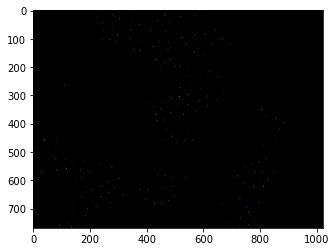

In [154]:
boundaries1, colors1 = Get_Cell_Boundaries(image_1,limit_1, foreground_mask_1, center_cordinate_1)
print(boundaries1)
print(np.unique(colors1))


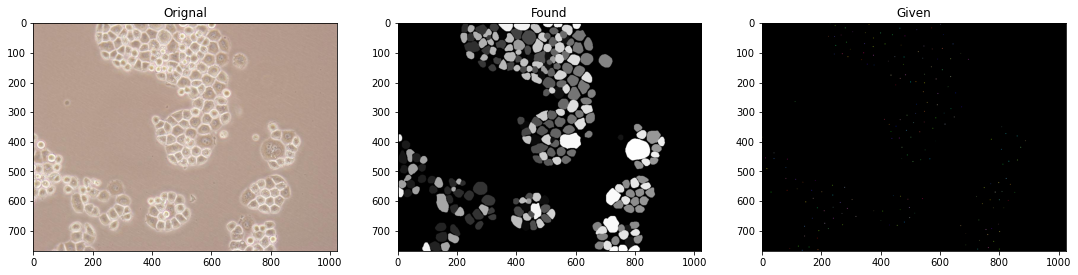

In [150]:
Plots(image_1, gold_cells_1, colors1,"1")

In [160]:

def Plot_color(image, color_file, found,file):
    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    
    fig.add_subplot(131)
    plt.title('Orignal')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    color_map = np.loadtxt(color_file, dtype='uint16')
    uniques = np.unique(color_map)
    unique_size = uniques.size
    rng = default_rng()
    vals = rng.integers(low=0, high=256, size=(unique_size, 3))
    vals[0] = np.array([0,0,0])


    color_3d_map = color.gray2rgb(color_map)
    for i in np.nditer(uniques):
        color_3d_map[color_map == i] = vals[i]
        color_3d_map = color_3d_map.astype('uint8')
    
    fig.add_subplot(132)
    plt.title('Given')
    plt.imshow(color_3d_map)
    
    fig.add_subplot(133)
    plt.title('Given')
    plt.imshow(found)
    
    save_file=file+'.png'
    plt.savefig(save_file)


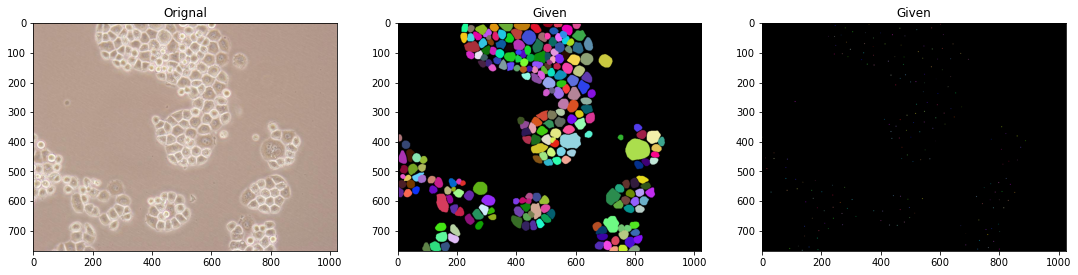

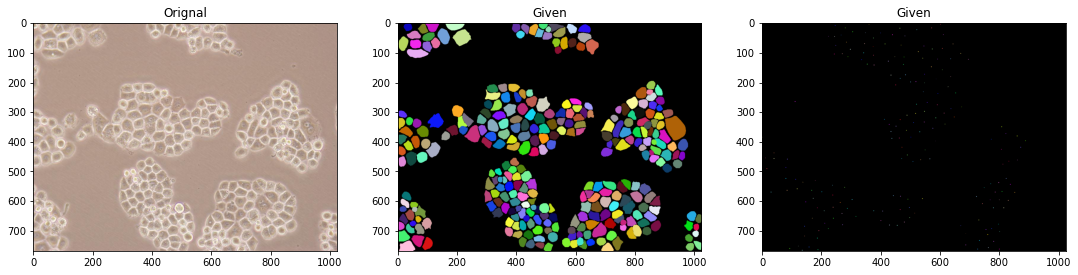

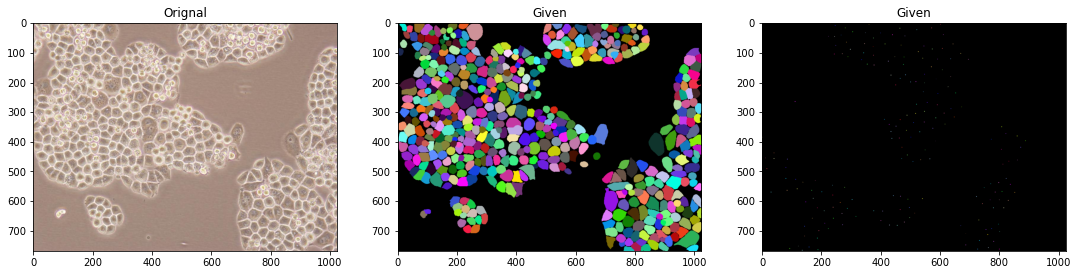

In [161]:
Plot_color(image_1, "data\im1_gold_cells.txt", colors1,"1")
Plot_color(image_2, "data\im2_gold_cells.txt", colors1,"2")
Plot_color(image_3, "data\im3_gold_cells.txt", colors1,"3")

In [ ]:

def ratio(img, i):
    return np.sum(img == i) / np.sum(img != 0)

def maximal_overlap(src, dst, cur):
    maximal, index = 0, 0
    for i in range(1, np.max(src)+1):
    cur_sum = np.sum(np.logical_and(src == i, dst == cur))
    if maximal < cur_sum:
        maximal, index = cur_sum, i
    di = 2 * maximal / (np.sum(src == index) + np.sum(dst == cur))
    return index, di

def calc_color_recall(given, found, ratio = 0.5,image_number):
    tp_cnt = 0
    gorund_truth=given
    num_ground_truth = np.max(ground_truth)
    num_found = np.max(found)
    mark = np.zeros(np.max(ground_truth))
    for i in range(1, num_found+1):
    marking = 0
    mx_marking = 0
    for j in range(1, num_ground_truth):
        if mark[j] == 1:
            continue
        cur_res = np.sum(np.logical_and(ground_truth == j, found == i))
        if mx_marking < cur_res:
            mx_marking = cur_res
            marking = j
    last_union = np.sum(np.logical_or(ground_truth == marking, found == i))
    if marking != 0 and mx_marking / last_union >= ratio:
        mark[marking] = 1
        tp_cnt += 1

    fp=np.max(found) - calc_color_tp(ground_truth, found, ratio)
    fn=np.max(ground_truth) - tp
    recall = tp / np.max(found)
    precision = tp / np.max(ground_truth)
    f_score= 2 * precision * recall / (precision + recall)
    print(" Image %s \n Pixel-level precision: %f \n Recall: %f \n F-score: %f"% (image_number,precision,recall,F_score))

def dice_index(ground_truth, found):
    res = 0

    whole_found = np.sum(found != 0)
    whole_ground = np.sum(ground_truth != 0)


    for i in range(1, np.max(found) + 1):
        grnd_i, di = maximal_overlap(ground_truth, found, i)
        res += di * (np.sum(found == i) / whole_found)
  
    for i in range(1, np.max(ground_truth) + 1):
        found_i, di = maximal_overlap(found, ground_truth, i)
        res += di * (np.sum(ground_truth == i) / whole_ground)
        res=res/2

    print(" Dice Index Value: %f"% (res))





In [ ]:
calc_color_recall(gold_cells_1, boundaries1, ratio = 0.5,"1"):
calc_color_recall(gold_cells_2, boundaries2, ratio = 0.5,"2"):
calc_color_recall(gold_cells_3, boundaries3, ratio = 0.5,"3"):
dice_index(gold_cells_1, boundaries1)
dice_index(gold_cells_2, boundaries2)
dice_index(gold_cells_3, boundaries3)